In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

# Paleta de Analisis

In [3]:
steps = 20
limit = 100

paleta_luminancia = np.array([
    (250/360, i/limit, 0)
    for i in range(0, limit, int(limit/steps))
])

In [78]:
def preprocess_luminance(img_hls):
    return img_hls[:, :, 1]

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        yield segment, get_subimage(img, mask == segment)

def get_rule_of_thirds_mask(img,n=3):
    original_x_size, original_y_size = img.shape[:2]
    
    mask_matrix = np.zeros(img.shape[:2])
    
    cnt = 0
    x_steps = list(range(0, original_x_size, int(np.ceil(original_x_size/n)))) + [original_x_size]
    y_steps = list(range(0, original_y_size, int(np.ceil(original_y_size/n)))) + [original_y_size]
    
    for from_x, to_x in list(zip(x_steps, x_steps[1:]))[:n]:
        for from_y, to_y in list(zip(y_steps, y_steps[1:]))[:n]:            
            mask_matrix[from_x:to_x, from_y:to_y] = cnt
            cnt += 1
    
    return mask_matrix

def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    flattened_values = []
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        median = np.median(mask_subimg[:,:,1])
        replacements[segment_idx] = median
        flattened_values.append(median)
        
    flat_mask = mask.flatten()
    return (pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape), flattened_values)

# Carga archivos

In [52]:
cam = glob.glob('../../../Osintgram/output/*.jpg')

In [82]:
img_rgb, img_hls = get_img(cam[4])

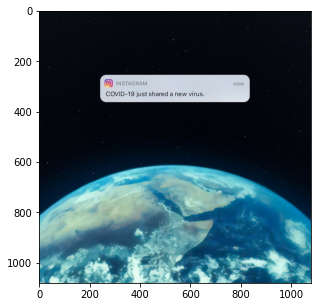

In [83]:
plt.imshow(img_rgb)

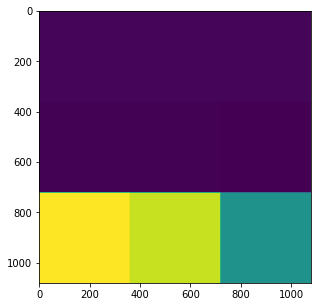

In [84]:
plt.imshow((get_luminance_weighted_mask(img_hls)[0] * (1/255)))

In [85]:
tuple(get_luminance_weighted_mask(img_hls)[1])

(11.0, 11.0, 11.0, 10.0, 10.0, 9.0, 139.0, 128.0, 76.0)

In [88]:
results = []
for img_path in tqdm(cam):
    img_hls = get_img(img_path)[1]
    
    results.append(tuple(get_luminance_weighted_mask(img_hls)[1]))

100%|██████████| 1537/1537 [01:46<00:00, 14.38it/s]


In [90]:
pd.DataFrame(results).to_csv('luminancias.csv', index=False)